# Creating the dataset from SPARC

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import csv
from scipy import interpolate

### Loading the two samples

In [ ]:
# Sample from table 2 : http://astroweb.cwru.edu/SPARC/ (for the velocity curves)

files = './raw_data/SPARC_rotational_curves/*.dat'
data = glob(files)
print("{} galaxies found".format(len(data)))

# Sample from table 1 : http://astroweb.cwru.edu/SPARC/ (for the luminosities [3.6] and effective radii)

df = pd.read_csv('./raw_data/SPARC_data_mass_models.csv')

### Useful functions

In [ ]:
def finding_index(name):
    return data.index('./raw_data/SPARC_rotational_curves/' + name + '_rotmod.dat')
i = finding_index('CamB')

def finding_name(galaxy):
    return galaxy.name

### Merging the two data samples and calculating stellar masses and dark matter fraction

In [ ]:
# Parameters in http://astroweb.cwru.edu/SPARC/

gammadisk = 0.5
gammabul = 0.7


# Calculating the stellar masses assuming M/L ratio is equal to 0.5 (Lelli 2016)

M = 0.5*df['L3_6']*10**9


class galaxy():
    def __init__(self, i):
        # Constructor method to initialize a galaxy object with index i
        self.index = i 
        # Index of the galaxy
        self.name = data[i].split('/')[-1].split('_')[0]
        # Extracting the name of the galaxy from the data file path
        self.radius = np.loadtxt(data[i])[:, 0]
        # Loading radius data from the data file
        self.Vobs = np.loadtxt(data[i])[:, 1]
        # Loading observed velocity data from the data file
        self.errV = np.loadtxt(data[i])[:, 2]
        # Loading error in velocity data from the data file
        self.Vgas = np.loadtxt(data[i])[:, 3]
        # Loading gas velocity data from the data file
        self.Vdisk = np.loadtxt(data[i])[:, 4]
        # Loading disk velocity data from the data file
        self.Vbul = np.loadtxt(data[i])[:, 5]
        # Loading bulge velocity data from the data file
        self.SBdisk = np.loadtxt(data[i])[:, 6]
        # Loading disk surface brightness data from the data file
        self.SBbul = np.loadtxt(data[i])[:, 7]
        # Loading bulge surface brightness data from the data file
        self.Vbar = None
        # Initializing attribute for baryons velocity
        self.fDM = None
        # Initializing attribute for dark matter fraction
        self.stellarmass = None
        # Initializing attribute for stellar mass
        self.effRad = None
        # Initializing attribute for effective radius
    

    def add_Vbar(self):
        # Method to calculate the velocity of the baryons
        Vbar = np.sqrt(abs(self.Vgas) * self.Vgas + gammadisk * abs(self.Vdisk) * self.Vdisk + gammabul * abs(self.Vbul) * self.Vbul)
        # Calculating the velocity of the baryons
        self.Vbar = Vbar
        return 1
        
    def add_fDM(self):
        # Method to calculate dark matter fraction
        if self.Vbar == None:
           self.add_Vbar() 
        # Checking if the velocity of the baryons has been calculated, if not, calculate it
        fDM = (self.Vobs**2 - self.Vbar**2) / (self.Vobs**2)
        # Calculating dark matter fraction
        self.fDM = fDM
        # Assigning calculated dark matter fraction to attribute
        return 1
        
    def isintwo(self):
        # Method to check if galaxy is in the two data samples
        if (len(np.where(df['Name'] == self.name)[0]) == 1):
            j = np.where(df['Name'] == self.name)[0][0]
            if (df['Qual'].iloc[j] == 1) and (df['Type'].iloc[j] < 10):
                return 1
            else:
                return 0
        else:
            return 0
            
    def add_stellarmass(self):
        # Method to add stellar mass data (in solar mass)
        if len(np.where(df['Name'] == self.name)[0]) != 0:
            # Checking if galaxy is in the two data samples
            Mass = M[np.where(df['Name'] == self.name)[0][0]]
            # Getting stellar mass from pre-calculated data
            self.stellarmass = Mass
            # Assigning stellar mass to attribute
        return 1
        
    def add_effRad(self):
        # Method to add effective radius data (in kpc)
        if len(np.where(df['Name'] == self.name)[0]) != 0:
            # Checking if galaxy is in the two data samples
            R = df['Reff'][np.where(df['Name'] == self.name)[0][0]]
            # Getting effective radius
            self.effRad = R
            # Assigning effective radius to attribute
        return 1


# Testing

firstgal = galaxy(i)

firstgal.add_fDM()
firstgal.add_stellarmass()
firstgal.add_effRad()


print(firstgal.fDM, firstgal.stellarmass)

### Making the final csv file

In [ ]:
# Open a CSV file for writing
with open('dataset/SPARC.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')

    # Write the name line and the unit line
    writer.writerow(["Name", "M*", "Reff", "fDM(Reff)", "sigma_fdm(Reff)", "fDM", "sigma_fdm", "Radius"])
    writer.writerow(["(SDSS)", "[Msun]", "[kpc]", "None", "None", "None", "None", "[kpc]"])

    # Loop through each element of data
    for i in range(len(data)):
        firstgal = galaxy(i)
        if firstgal.isintwo():
            firstgal.add_fDM()
            firstgal.add_stellarmass()
            firstgal.add_effRad()

            # Extracting necessary data
            name = firstgal.name
            errV = firstgal.errV
            Mass = firstgal.stellarmass
            effRad = firstgal.effRad
            rad = firstgal.radius
            rad_str = ", ".join(map(str, rad))  # Convert the NumPy array to a string
            fDM = firstgal.fDM
            fDM_str = ", ".join(map(str, fDM))
            fDMeff = np.interp(effRad, rad, firstgal.fDM)
            sigma_fdm = np.sqrt((2 * firstgal.Vbar**2 / firstgal.Vobs**3 * errV)**2)
            sigma_fdm_str = ", ".join(map(str, sigma_fdm))
            sigma_fdmeff = np.sqrt((2 * np.interp(effRad, rad, firstgal.Vbar)**2 / np.interp(effRad, rad, firstgal.Vobs)**3 * np.interp(effRad, rad, errV))**2)

            # Write the data to the CSV file with commas as separators
            writer.writerow([name, Mass, effRad, fDMeff, sigma_fdmeff , fDM_str, sigma_fdm_str, rad_str])
            
# Read the CSV file into a DataFrame
sparc = pd.read_csv('dataset/SPARC.csv')
# Test
print(sparc['fDM'].iloc[1])


In [24]:
file = './raw_data/SPARC_data_mass_models.txt'
data = np.genfromtxt(file, usecols=0, dtype="str")
galaxy_names = data[:] # Galaxy identifier

data = np.genfromtxt(file, usecols=(1,5,7,8,9,17))
Luminosity = data[:,2] * 1e9 # [Lsun]
ErrorLuminosity = data[:,3] * 1e9 # [Lsun]
Mstellar = 0.5 * Luminosity  # [Msun]; here we assume a mass-to-light ratio of 0.5
size = data[:,4] # [kpc]; Effective Radius at [3.6]
Q = data[:,5] # Quality flag

num_sample = len(galaxy_names)
fDM = np.zeros(num_sample)
ErrorfDM = np.zeros(num_sample)

gamma_disc = 0.5   # Mass-to-light ratio for the disc
gamma_bulge = 0.7  # Mass-to-light ratio for the bulge

for i, galaxy in enumerate(galaxy_names):
    file = './raw_data/Sparc_rotational_curves/' + galaxy + '_rotmod.dat'
    data = np.genfromtxt(file)
    r = data[:, 0]
    Vobs = data[:, 1]
    Verr = data[:, 2]

    Vgas = data[:, 3]
    Vdisk = data[:, 4]
    Vbulge = data[:, 5]

    Vstar2 = gamma_disc * Vdisk ** 2 + gamma_bulge * Vbulge ** 2 # Stellar rotational curve
    Vbar2 = Vgas ** 2 + Vstar2 # Baryonic rotational curve

    if r[-1] < size[i]: continue # No data at galaxy size

    if (size[i] > np.min(r)) & (size[i] < np.max(r)):
        DM_fraction = (Vobs**2 - Vbar2) / Vobs**2
        f = interpolate.interp1d(r, DM_fraction)
        fDM[i] = f(size[i])
        Error_DM_fraction = 2 * (Vbar2 / Vobs**2) * (Verr/Vobs) # Here we do error propagation
        f = interpolate.interp1d(r, Error_DM_fraction)
        ErrorfDM[i] = f(size[i])
        

In [25]:
select = np.where((size>0) & (Mstellar>0) & (fDM>=0))[0] # We remove from the sample bad estimates
galaxy_names = galaxy_names[select]
fDM = fDM[select]
ErrorfDM = ErrorfDM[select]
Q = Q[select]
Mstellar = Mstellar[select]
size = size[select]
num_sample = len(select)

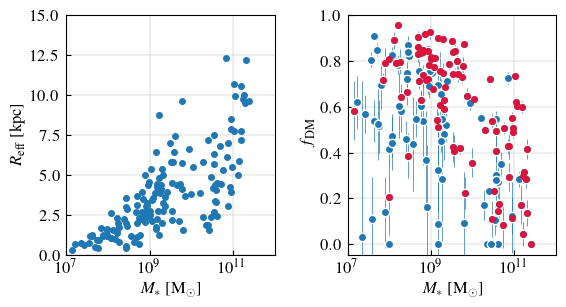

In [26]:
#################
# Plot parameters
params = {
    "font.size": 12,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (7, 3),
    "figure.subplot.left": 0.25,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.15,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.35,
    "figure.subplot.hspace": 0.35,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(Mstellar, size, 'o', ms=4)

plt.axis([1e7, 1e12, 0, 15])
plt.xscale('log')
plt.ylabel(r"$R_{\mathrm{eff}}$ [kpc]")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)

######
ax = plt.subplot(1, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)

plt.errorbar(Mstellar, fDM, yerr=ErrorfDM, marker='o', markersize=6, markeredgecolor="white", 
             ls='none', lw=0.5, c='tab:blue')

select_quality = np.where(Q == 1)[0]
plt.plot(Mstellar[select_quality], fDM[select_quality], 'o', ms=4, color='crimson',zorder=1000)

plt.axis([1e7, 1e12, -0.05, 1])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.show()

In [28]:
# Writing the data into a CSV file
with open('dataset/SPARC.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["GalaxyName","M*[Msun]", "Reff[kpc]","fDM(Reff)", "ErrorfDM", "QualityFlag"])

    # Looping through each element of the data
    for i in range(num_sample):

        Name = galaxy_names[i]
        Mi = Mstellar[i]
        fDMi = fDM[i]
        Ri = size[i]
        efdm = ErrorfDM[i]
        Qi = Q[i]
        # Writing the data into the CSV file
        writer.writerow([Name, Mi, Ri, fDMi, efdm, Qi])
        

In [29]:
import pandas as pd
# Reading the CSV file into a DataFrame
sparc = pd.read_csv('dataset/SPARC.csv')
sparc

,GalaxyName,M*[Msun],Reff[kpc],fDM(Reff),ErrorfDM,QualityFlag
0,CamB,37500000.0,1.21,0.110503,0.183534,2.0
1,D512-2,162500000.0,2.37,0.784796,0.040556,2.0
2,D564-8,16500000.0,0.72,0.620737,0.115476,2.0
3,D631-7,98000000.0,1.22,0.203714,0.162912,1.0
4,DDO064,78500000.0,1.20,0.793443,0.062943,1.0
...,...,...,...,...,...,...
152,UGC12632,650500000.0,3.94,0.849338,0.016080,1.0
153,UGC12732,833500000.0,3.12,0.843298,0.022343,1.0
154,UGCA281,97000000.0,1.57,0.000000,0.000000,3.0
155,UGCA442,70000000.0,1.71,0.716631,0.029675,1.0
